# plot_transition.ipynb

Author: Robert M. Frost

University of Oklahoma

Created: 24 October 2023

Purpose: Plot figures to be used in BLM manuscript

In [81]:
import sys
sys.path.append("/home/rfrost/LES-utils/")

import seaborn
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from LESutils import load_full
import seaborn
import cmocean
from matplotlib.gridspec import GridSpec

## Settings

In [82]:
# directory to save figures
figdir = "/home/rfrost/manuscript_plots/"
# simulation to analyze
sim = "full_step_15"
dnc = f"/home/rfrost/simulations/nc/{sim}/"

# z/zi to plot
height = 0.25

# start and end timesteps
t0 = 576000
t1 = 1152000
# start and end in hours
t0hr = t0 * 0.05 / 3600
t1hr = t1 * 0.05 / 3600
# spacing of output
dt = 1000

In [83]:
# plotting setup
rc('font',weight='normal',size=20,family='serif',serif='Times New Roman')
rc('text',usetex='True')
rc('figure',facecolor='white')

# Cross-sections

In [84]:
timesteps = np.arange(t0, t1, dt, dtype=np.int32)
t = (0.05 * timesteps)/3600. # reset to 8

# grab the timesteps for loading
# array of times
tload = np.array([9.5, 11, 12.5, 14, 15.5]) # hrs
# loop to find nearest timestep
jt1 = np.array([np.argmin(np.abs(t - tt)) for tt in tload])
# number of timesteps
nt = len(tload)

In [85]:
# construct filenames
f1 = [f"{dnc}all_{timesteps[jt]:07d}.nc" for jt in jt1]
# load mf dataset
d1 = xr.open_mfdataset(f1, combine="nested", concat_dim="time")
d1.coords["time"] = t[jt1]
d1.time.attrs["units"] = "hr"

In [86]:
# calculate "inst" covar based on xy planar averages
# averages and perturbations
for v in ["u", "v", "w", "theta"]:
    d1[f"{v}_mean"] = d1[v].mean(dim=("x", "y"))
    d1[f"{v}_pert"] = d1[v] - d1[f"{v}_mean"]
# covars
d1["uw"] = (d1.u - d1.u_mean) * (d1.w - d1.w_mean) + d1.txz
d1["vw"] = (d1.v - d1.v_mean) * (d1.w - d1.w_mean) + d1.tyz
d1["tw"] = (d1.theta - d1.theta_mean) * (d1.w - d1.w_mean) + d1.q3
# vars
d1["uu"] = (d1.u - d1.u_mean) * (d1.u - d1.u_mean)
d1["vv"] = (d1.v - d1.v_mean) * (d1.v - d1.v_mean)
d1["ww"] = (d1.w - d1.w_mean) * (d1.w - d1.w_mean)
d1["tt"] = (d1.theta - d1.theta_mean) * (d1.theta - d1.theta_mean)

# calculate averages
d1["uw_cov_tot"] = d1.uw.mean(dim=("x","y"))
d1["vw_cov_tot"] = d1.vw.mean(dim=("x","y"))
d1["tw_cov_tot"] = d1.tw.mean(dim=("x","y"))
d1["uu_var"] = d1.uu.mean(dim=("x","y"))
d1["vv_var"] = d1.vv.mean(dim=("x","y"))
d1["ww_var"] = d1.ww.mean(dim=("x","y"))
d1["tt_var"] = d1.tt.mean(dim=("x","y"))

# calculate zi
idx = d1.tw_cov_tot.argmin(axis=1)
d1["zi"] = d1.z[idx]
# calculate ustar
d1["ustar2"] = ((d1.uw_cov_tot**2) + (d1.vw_cov_tot**2.)) ** 0.5
# calculate wstar
d1["wstar"] = ((9.81/d1.theta_mean.isel(z=0))*d1.tw_cov_tot.isel(z=0)*d1.zi)**(1/3)
# theta star
d1["thetastar"] = d1.tw_cov_tot[:,0] / d1.wstar

### cross sections of $\langle w' / w_* \rangle$, $\langle u' / w_* \rangle$, and $\langle \theta' / \theta_* \rangle$

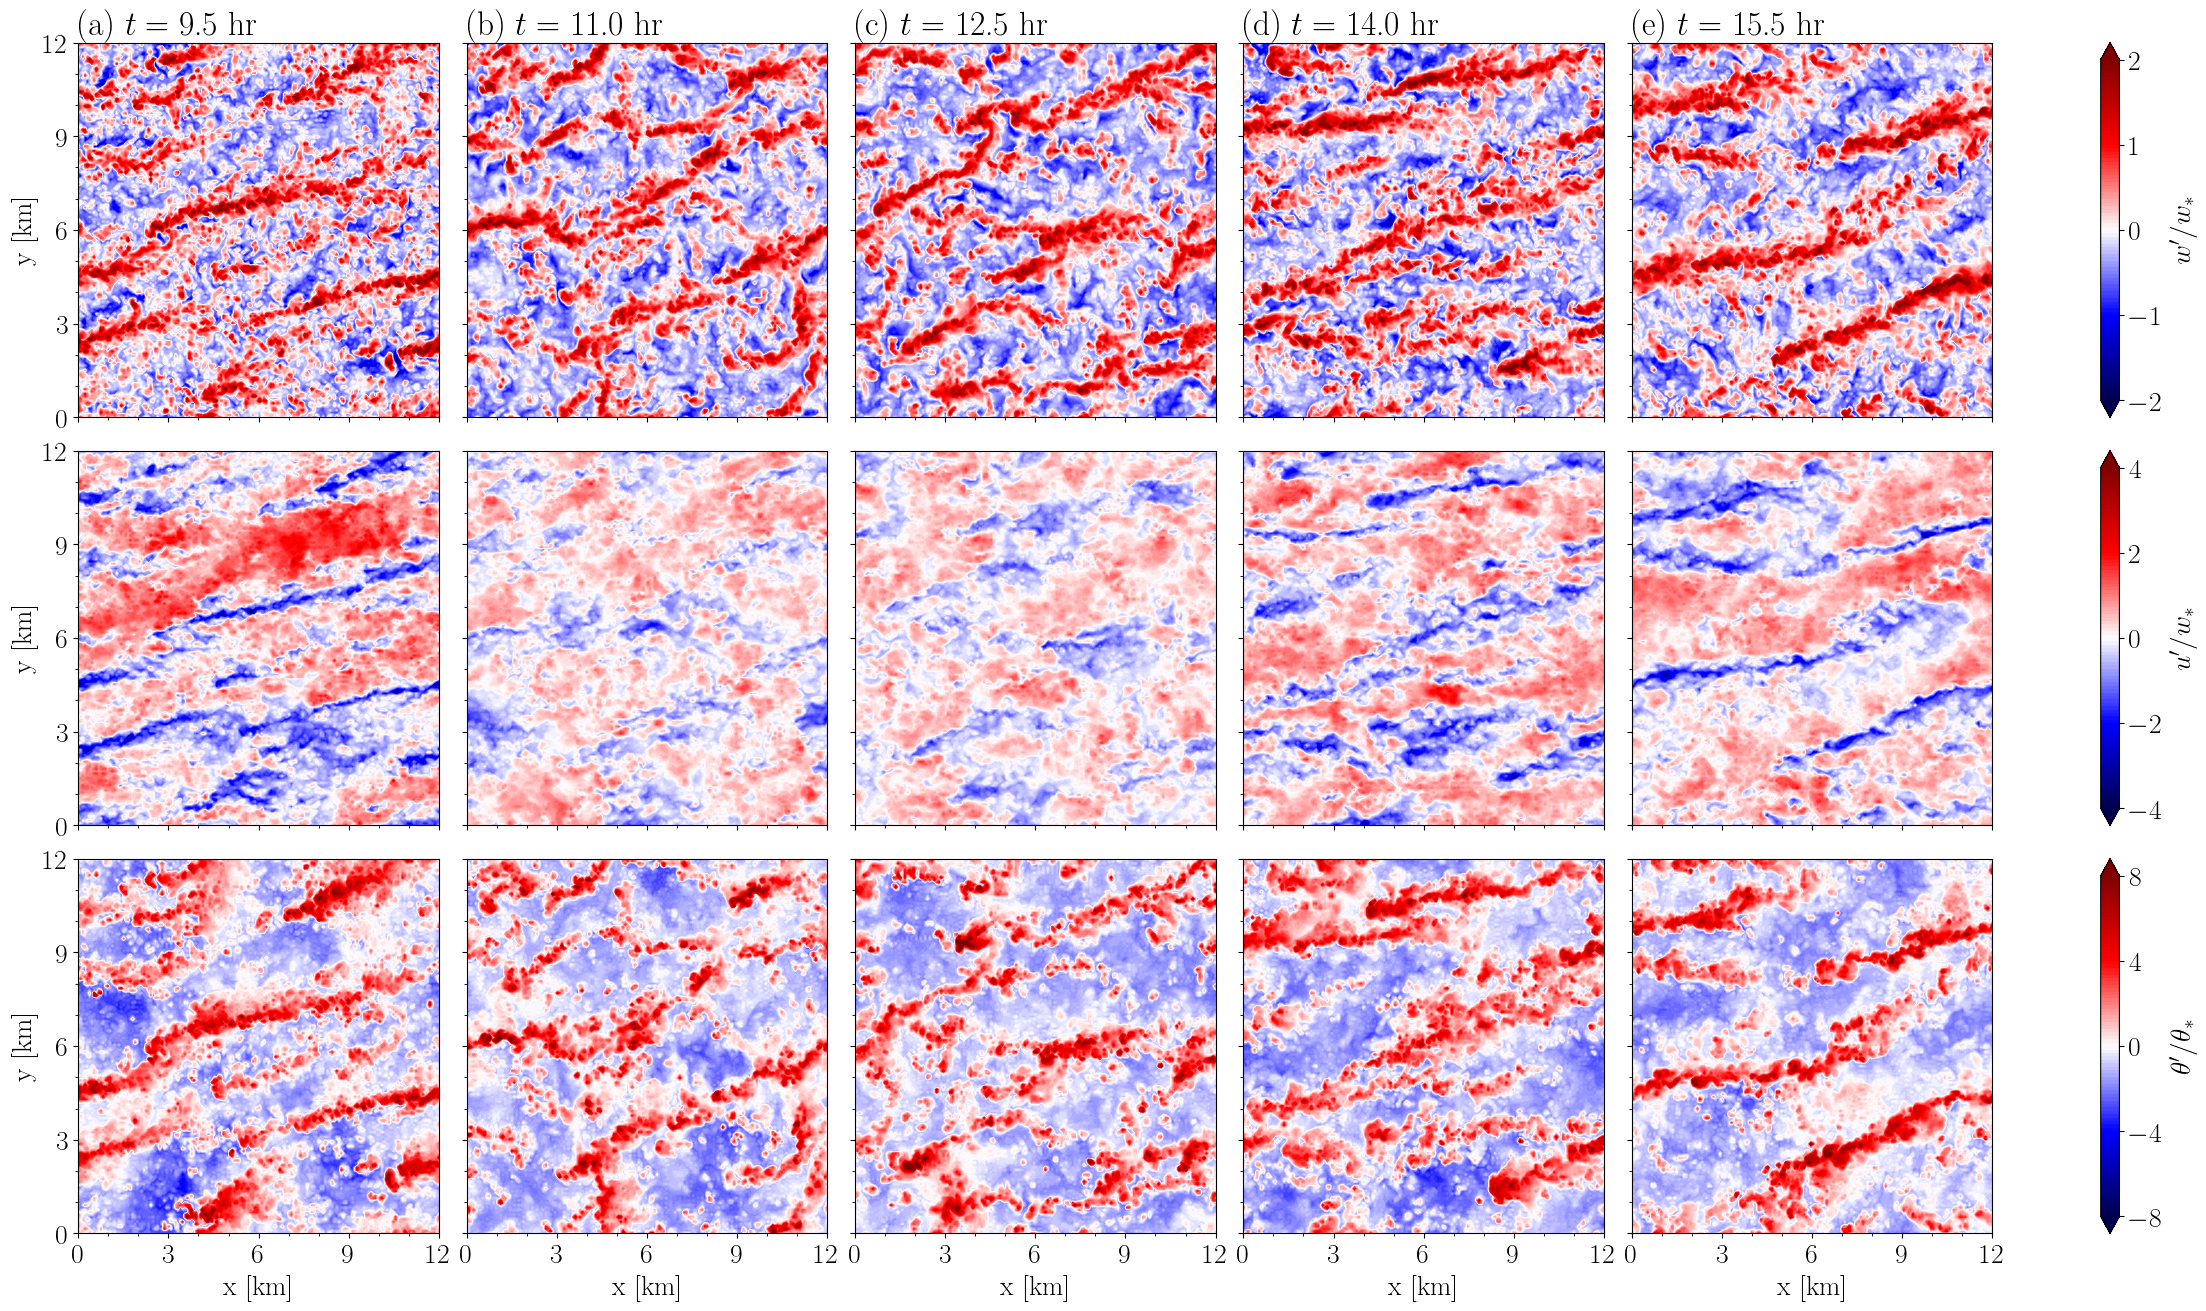

In [87]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(22,13), 
                       sharex=True, sharey=True, constrained_layout=True)

# levels to plot
clevsw = np.linspace(-2,2,101)
clevsu = np.linspace(-4,4,101)
clevst = np.linspace(-8,8,101)

# keep track of cfaxis handles
cfax1 = []
# loop over timesteps and plot in each panel
for jt, iax in enumerate(ax[0,:].flatten()):
    # calc z/zi
    jzi = d1.tw.isel(time=jt).mean(dim=("x","y")).argmin().values
    zzi = d1.z/d1.z[jzi]
    jz = abs(zzi - height).argmin()
    # contour
    cfax = iax.contourf(d1.x/1000, d1.y/1000, d1.w_pert.isel(time=jt, z=jz).T / d1.wstar[jt],
                        levels=clevsw, cmap=mpl.cm.seismic, extend="both")
    # keep cf handle
    cfax1.append(cfax)

# keep track of cfaxis handles
cfax2 = []
# loop over timesteps and plot in each panel
for jt, iax in enumerate(ax[1,:].flatten()):
    # calc z/zi
    jzi = d1.tw.isel(time=jt).mean(dim=("x","y")).argmin().values
    zzi = d1.z/d1.z[jzi]
    jz = abs(zzi - height).argmin()
    # contour
    cfax = iax.contourf(d1.x/1000, d1.y/1000, d1.u_pert.isel(time=jt, z=jz).T / d1.wstar[jt],
                        levels=clevsu, cmap=mpl.cm.seismic, extend="both")
    # keep cf handle
    cfax2.append(cfax)
    
# keep track of cfaxis handles
cfax3 = []
# loop over timesteps and plot in each panel
for jt, iax in enumerate(ax[2,:].flatten()):
    # calc z/zi
    jzi = d1.tw.isel(time=jt).mean(dim=("x","y")).argmin().values
    zzi = d1.z/d1.z[jzi]
    jz = abs(zzi - height).argmin()
    # contour
    cfax = iax.contourf(d1.x/1000, d1.y/1000, d1.theta_pert.isel(time=jt, z=jz).T / d1.thetastar[jt],
                        levels=clevst, cmap=mpl.cm.seismic, extend="both")
    # keep cf handle
    cfax3.append(cfax)

# colorbars
cbw = plt.colorbar(cfax1[0], ax=ax[0,:], orientation='vertical')
cbw.set_label("$w'/w_*$")
cbw.set_ticks(np.arange(-2,2.1,1))
cbu = plt.colorbar(cfax2[0], ax=ax[1,:], orientation='vertical')
cbu.set_label("$u'/w_*$")
cbu.set_ticks(np.arange(-4,4.1,2))
cbt = plt.colorbar(cfax3[0], ax=ax[2,:], orientation='vertical')
cbt.set_label("$\\theta' / \\theta_*$")
cbt.set_ticks(np.arange(-8,8.1,4))

# figure titles
for jt, (iax, lab) in enumerate(zip(ax[0,:].flatten(), list("abcde"))):
    iax.set_title(f"({lab}) $t =$ {d1.time[jt].values} hr", loc="left")

# axis labels
for i, iax in enumerate(ax[:,0]):
    iax.set_ylabel("y [km]")
    iax.yaxis.set_major_locator(MultipleLocator(3))
    iax.yaxis.set_minor_locator(MultipleLocator(1))
for i, iax in enumerate(ax[2,:]):
    iax.set_xlabel("x [km]")
    iax.xaxis.set_major_locator(MultipleLocator(3))
    iax.xaxis.set_minor_locator(MultipleLocator(1))

# save fig
fig.savefig(f"{figdir}{sim}_3x5.png")

# Time series

In [88]:
# volumetric stats
stats = xr.open_dataset(f"{dnc}{t0}_{t1}_stats.nc")

# calculate large eddy turnover time
TL = stats.zi.isel(time=0) / stats.wstar.isel(time=0)
TL = TL / 3600

# convert time to hours
stats["time"] = stats.time / 3600 + t0hr
# extract size of time dimension
ntime = stats.time.size
# extract maximum zi value
maxzi_idx = np.argmax(stats.zi.values)
maxzi = stats.zi[maxzi_idx].values

# calculate entrainment rate
# zi_filtered = stats.zi.coarsen(time=6, boundary="trim").mean()
# stats["dzi_dt"] = np.gradient(zi_filtered)

In [89]:
wvar = np.zeros(ntime)
uvar = np.zeros(ntime)

for jt in range(ntime):
    jz = abs(stats.z/stats.zi[jt] - height).argmin()
    wvar[jt] = stats.w_var[jt,jz]
    uvar[jt] = stats.u_var[jt,jz]

### time series of $z_i$, $z_i / L$, and $\langle \sigma_{w}^2 / \sigma_{u}^2 \rangle$

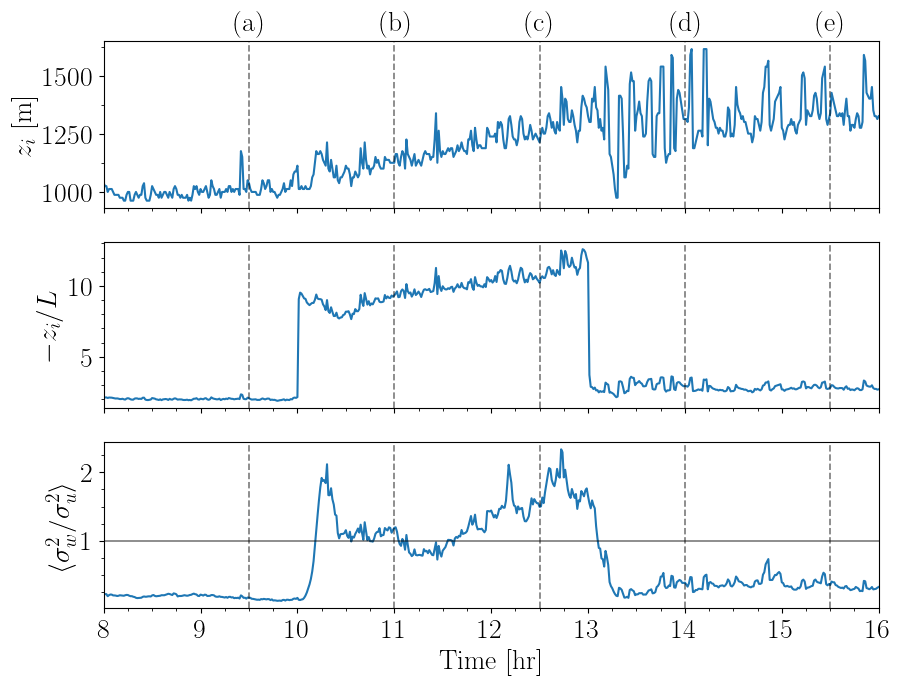

In [99]:
fig, ax = plt.subplots(figsize=(10,7), nrows=3, sharex=True)

# zi
ax[0].plot(stats.time, stats.zi)
# -zi/L
ax[1].plot(stats.time, stats.zi_L)
# wvar / uvar
ax[2].plot(stats.time, (wvar ** 2 / uvar ** 2))

# axis labels
ax[0].set_ylabel("$z_i$ [m]")
ax[1].set_ylabel("$-z_i / L$")
ax[2].set_ylabel("$\\langle \sigma_{w}^2 / \sigma_{u}^2 \\rangle$")
ax[2].set_xlabel("Time [hr]")
# axis limits
ax[2].set_xlim(8,16)

# add vertical lines
for iax in ax:
    # plotting times
    iax.axvline(x=9.5, ls="--", c="black", alpha=0.5, lw=1.25)
    iax.axvline(x=11, ls="--", c="black", alpha=0.5, lw=1.25)
    iax.axvline(x=12.5, ls="--", c="black", alpha=0.5, lw=1.25)
    iax.axvline(x=14, ls="--", c="black", alpha=0.5, lw=1.25)
    iax.axvline(x=15.5, ls="--", c="black", alpha=0.5, lw=1.25)
    # minor ticks on x axis
    iax.xaxis.set_minor_locator(MultipleLocator(0.25))

# add horizontal line
ax[2].axhline(y=1, ls="-", c="black", alpha=0.5, lw=1.25)

# add minor ticks to y axis
ax[0].yaxis.set_minor_locator(MultipleLocator(125))
ax[1].yaxis.set_minor_locator(MultipleLocator(1))
ax[2].yaxis.set_minor_locator(MultipleLocator(.25))

# add text above lines
ax[0].text(9.35, maxzi+80, "(a)")
ax[0].text(10.85, maxzi+80, "(b)")
ax[0].text(12.35, maxzi+80, "(c)")
ax[0].text(13.85, maxzi+80, "(d)")
ax[0].text(15.35, maxzi+80, "(e)")

# Reduce the space between the title and the top of the figure
plt.subplots_adjust(top=0.92)  

fig.tight_layout
# plt.suptitle(f"$U_g$ = {ug} [m s$^{{-1}}$]")
plt.show()
plt.close()

In [104]:
min_stats = stats.where(stats.time >= 13, drop=True)
jt_min = np.argmin(min_stats.zi.values)

<bound method Figure.tight_layout of <Figure size 1100x1100 with 4 Axes>>

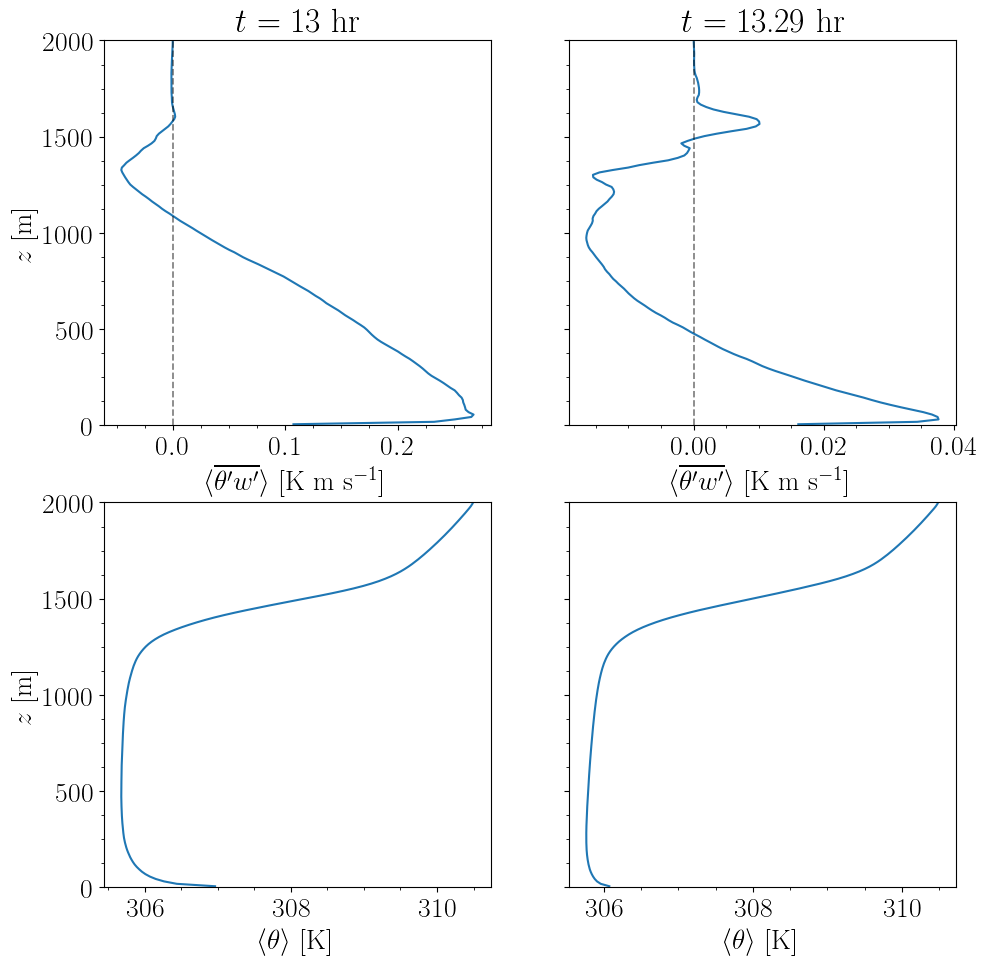

In [130]:
fig, ax = plt.subplots(nrows=2, ncols=2 ,figsize=(11,11), sharey=True)

# t'w'
ax[0,0].plot(min_stats.tw_cov_res[0], min_stats.z)
ax[0,1].plot(min_stats.tw_cov_res[jt_min], min_stats.z)
# theta
ax[1,0].plot(min_stats.theta_mean[0], min_stats.z)
ax[1,1].plot(min_stats.theta_mean[jt_min], min_stats.z)

for i, iax in enumerate(ax[:,0]):
    # axis limits
    iax.set_ylim(0,2000)
    # axis labels
    iax.set_ylabel("$z$ [m]")
    # set ticks
    iax.yaxis.set_minor_locator(MultipleLocator(125))

for i, iax in enumerate(ax[0,:]):
    # vertical lines
    iax.axvline(x=0, ls="--", c="black", alpha=0.5, lw=1.25)
    # axis labels
    iax.set_xlabel("$\\langle \overline{\\theta'w'} \\rangle$ [K m s$^{-1}$]")

for i, iax in enumerate(ax[1,:]):
    iax.set_xlabel("$\\langle \\theta \\rangle$ [K]")

# set ticks
ax[0,0].xaxis.set_minor_locator(MultipleLocator(.025))
ax[0,1].xaxis.set_minor_locator(MultipleLocator(.005))
ax[1,0].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[1,1].xaxis.set_minor_locator(MultipleLocator(0.5))

# titles
rounded_time = np.round(min_stats.time[jt_min].values, 2)
ax[0,0].set_title("$t$ = 13 hr")
ax[0,1].set_title(f"$t$ = {rounded_time} hr")

fig.tight_layout

# $R$ and length scale ratio

In [93]:
# roll factor
roll = xr.open_dataarray(f"{dnc}rollfactor.nc")
# convert time to hours
roll["time"] = (roll.time) / 3600 + t0hr

# length scales
ls = xr.open_dataset(f"{dnc}{t0}_{t1}_length_scale_rot.nc")
ls["time"] = ls.time / 3600 + t0hr
# ls ratio
ls_ratio = np.empty(ls.time.size )
for jt in range(ls.time.size):
    jz = abs(stats.z/stats.zi[jt] - height).argmin()
    ls_ratio[jt] = ls.rolls[jt,jz] / ls.normal[jt,jz]

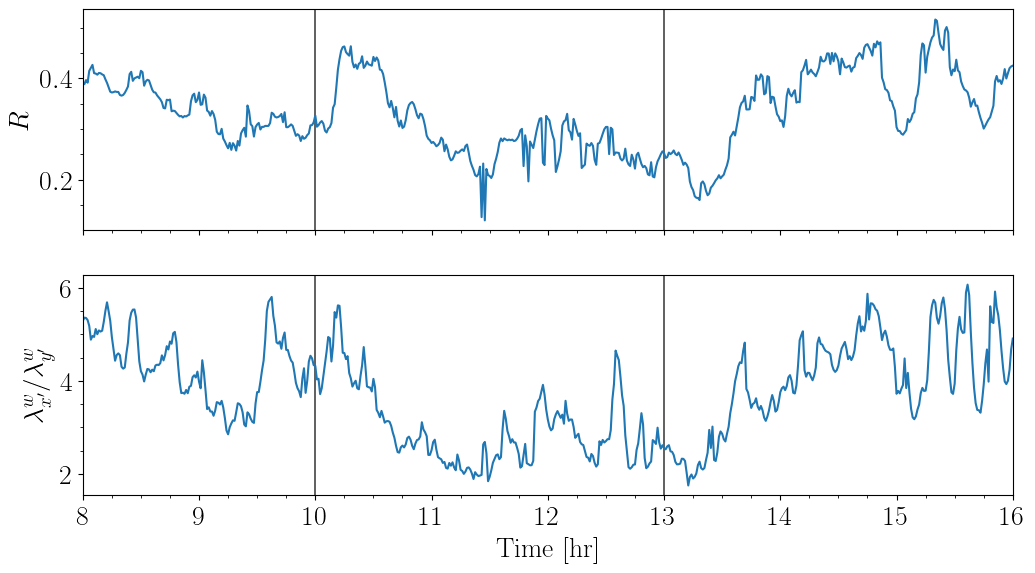

In [94]:
fig, ax = plt.subplots(figsize=(12,6), nrows=2, sharex=True)

# roll factor
ax[0].plot(roll.time, roll[1], zorder=2)
# length scales
ax[1].plot(ls.time, ls_ratio, zorder=2)

# clean up
ax[0].set_ylabel("$R$")
ax[1].set_ylabel("$ \lambda_{x'}^{w} / \lambda_{y'}^{w} $")
ax[1].set_xlabel("Time [hr]")
ax[1].set_xlim(8,16)

# add vertical lines
for iax in ax:
    iax.axvline(x=10, ls="-", c="black", alpha=0.7, lw=1.25, zorder=1)
    iax.axvline(x=13, ls="-", c="black", alpha=0.7, lw=1.25, zorder=1)
    # minor ticks on x axis
    iax.xaxis.set_minor_locator(MultipleLocator(0.25))

# add minor ticks to y axis
ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.5))

# Reduce the space between the title and the top of the figure
plt.subplots_adjust(top=0.92)  

fig.tight_layout
plt.show()
plt.close()

In [95]:
# fig = plt.figure(figsize=(23,23))

# gs1 = GridSpec(1, 1, bottom=0.6, wspace=0.05)
# ax1 = fig.add_subplot(gs1[:,:])
# gs2 = GridSpec(3, 5, top=0.55)
# ax2 = fig.add_subplot(gs2[0,0])
# ax3 = fig.add_subplot(gs2[0,1])
# ax4 = fig.add_subplot(gs2[0,2])
# ax5 = fig.add_subplot(gs2[0,3])
# ax6 = fig.add_subplot(gs2[0,4])
# ax7 = fig.add_subplot(gs2[1,0])
# ax8 = fig.add_subplot(gs2[1,1])
# ax9 = fig.add_subplot(gs2[1,2])
# ax10 = fig.add_subplot(gs2[1,3])
# ax11 = fig.add_subplot(gs2[1,4])
# ax12 = fig.add_subplot(gs2[2,0])
# ax13 = fig.add_subplot(gs2[2,1])
# ax14 = fig.add_subplot(gs2[2,2])
# ax15 = fig.add_subplot(gs2[2,3])
# ax16 = fig.add_subplot(gs2[2,4])